In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

Using TensorFlow backend.


train data shape:(199, 7), test data shape:(199, 6)


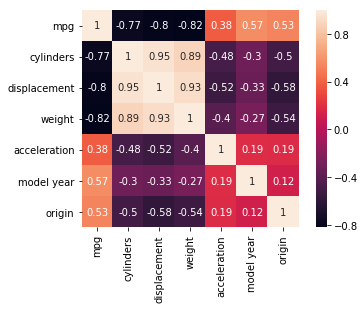

In [5]:
train_df = pd.read_table('../input/train.tsv')
test_df = pd.read_table('../input/test.tsv')
drop_list = ['car name', 'horsepower', 'id']
train_df.drop(drop_list, axis=1, inplace=True)
test_id = test_df.id.values
test_df.drop(drop_list, axis=1, inplace=True)
feature_list = ['weight', 'model year']
print("train data shape:{}, test data shape:{}".format(train_df.shape, test_df.shape))
# train_df.replace('?', 'NaN')
# test_df = test_df.replace('?', 'NaN')
corr = train_df.corr()
sns.heatmap(corr, square=True, annot=True);

In [3]:
# Model
N = 5
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler 
from sklearn.svm import SVC
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
# 線形SVMのインスタンスを生成
model = LogisticRegression(random_state=None)
lr = LinearRegression()

kf = KFold(n_splits=N)
test_pred = np.zeros(len(test_df))
accuracy_train = []
index = 1
for train, test in kf.split(train_df):
    X_train = train_df.iloc[train]
    y_train = X_train['mpg'].values
    #X_train = X_train[feature_list].values
    X_train = X_train.drop('mpg', axis=1).values
    
    X_test = train_df.iloc[test]
    y_test = X_test['mpg'].values
    #X_test = X_test[feature_list].values
    X_test = X_test.drop('mpg', axis=1).values

    sc = StandardScaler()
    sc.fit(X_train)
#     X_train_std = sc.transform(X_train)
#     X_test_std = sc.transform(X_test)

    #model.fit(X_train, y_train)
    lr.fit(X_train, y_train)
    pred_train = lr.predict(X_test)
    #test_data = test_df[feature_list].values
    test_data = test_df.values
    test_pred += lr.predict(test_data)/N
    accuracy_train.append(np.sqrt(mean_squared_error(y_test, pred_train)))
    print('Fold {} CV RMSE: {:.6}'.format(index, accuracy_train[-1]))
    index += 1
print('CV average RMSE: {:.6}'.format(sum(accuracy_train)/len(accuracy_train)))

Fold 1 CV RMSE: 3.51634
Fold 2 CV RMSE: 3.60596
Fold 3 CV RMSE: 2.72074
Fold 4 CV RMSE: 3.65165
Fold 5 CV RMSE: 3.38527
CV average RMSE: 3.37599


In [4]:
import csv
f = open('LinearRegression.csv', 'w')
writer = csv.writer(f, lineterminator='\n')
csvlist = [[] for i in range(len(test_pred))]
for i in range(len(test_pred)):
    csvlist[i].append(test_id[i])
    csvlist[i].append(test_pred[i])
    writer.writerow(csvlist[i])
f.close()

In [5]:
import lightgbm as lgb

kf = KFold(n_splits=N)
test_pred = np.zeros(len(test_df))
accuracy_train = []
index = 1
for train, test in kf.split(train_df):
    X_train = train_df.iloc[train]
    y_train = X_train['mpg'].values
    X_train = X_train[feature_list].values
    
    X_test = train_df.iloc[test]
    y_test = X_test['mpg'].values
    X_test = X_test[feature_list].values

    train_data_set = lgb.Dataset(X_train, y_train)
    test_data_set = lgb.Dataset(X_test, y_test, reference=train_data_set)

    params = {                                                                                               
        'boosting_type': 'gbdt',                                                                             
        'objective': 'regression_l2',                                                        
        'metric': 'RMSE',                                               
        'num_leaves': 40,                                                      
        'learning_rate': 0.05,                                                         
        'feature_fraction': 0.9,                                                                  
        'bagging_fraction': 0.8,                                                                       
        'bagging_freq': 5,
        'lambda_l2': 2,
    }                                                                                                        

    gbm = lgb.train(params,                                                                                  
                    train_data_set,                                                                               
                    num_boost_round=200,                                                                      
                    valid_sets=test_data_set,                                                                     
                    early_stopping_rounds=10
                    )
    pred_train = gbm.predict(X_test, num_iteration=gbm.best_iteration)

    test_data = test_df[feature_list].values
    test_pred += gbm.predict(test_data, num_iteration=gbm.best_iteration)/N
    accuracy_train.append(np.sqrt(mean_squared_error(y_test, pred_train)))
    print('Fold {} CV RMSE: {:.6}'.format(index, accuracy_train[-1]))
    index += 1
print('CV average RMSE: {:.6}'.format(sum(accuracy_train)/len(accuracy_train)))


[1]	valid_0's rmse: 7.56221
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 7.31563
[3]	valid_0's rmse: 7.16929
[4]	valid_0's rmse: 6.94001
[5]	valid_0's rmse: 6.8045
[6]	valid_0's rmse: 6.59938
[7]	valid_0's rmse: 6.46743
[8]	valid_0's rmse: 6.26551
[9]	valid_0's rmse: 6.1438
[10]	valid_0's rmse: 5.96797
[11]	valid_0's rmse: 5.88069
[12]	valid_0's rmse: 5.70629
[13]	valid_0's rmse: 5.62647
[14]	valid_0's rmse: 5.46488
[15]	valid_0's rmse: 5.39199
[16]	valid_0's rmse: 5.25285
[17]	valid_0's rmse: 5.18144
[18]	valid_0's rmse: 5.05331
[19]	valid_0's rmse: 4.97037
[20]	valid_0's rmse: 4.8529
[21]	valid_0's rmse: 4.77404
[22]	valid_0's rmse: 4.65712
[23]	valid_0's rmse: 4.58516
[24]	valid_0's rmse: 4.48093
[25]	valid_0's rmse: 4.41504
[26]	valid_0's rmse: 4.31608
[27]	valid_0's rmse: 4.25916
[28]	valid_0's rmse: 4.16792
[29]	valid_0's rmse: 4.1272
[30]	valid_0's rmse: 4.04401
[31]	valid_0's rmse: 4.01372
[32]	valid_0's rmse: 3.94381
[33]	valid_0's rmse: 3.

/Users/reo/.pyenv/versions/anaconda3-5.3.0/envs/Kaggle/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


[35]	valid_0's rmse: 3.82081
[36]	valid_0's rmse: 3.75529
[37]	valid_0's rmse: 3.7156
[38]	valid_0's rmse: 3.656
[39]	valid_0's rmse: 3.62011
[40]	valid_0's rmse: 3.56603
[41]	valid_0's rmse: 3.54387
[42]	valid_0's rmse: 3.49128
[43]	valid_0's rmse: 3.47242
[44]	valid_0's rmse: 3.4276
[45]	valid_0's rmse: 3.39649
[46]	valid_0's rmse: 3.36493
[47]	valid_0's rmse: 3.34367
[48]	valid_0's rmse: 3.31505
[49]	valid_0's rmse: 3.29578
[50]	valid_0's rmse: 3.26987
[51]	valid_0's rmse: 3.2568
[52]	valid_0's rmse: 3.22991
[53]	valid_0's rmse: 3.21796
[54]	valid_0's rmse: 3.19415
[55]	valid_0's rmse: 3.18351
[56]	valid_0's rmse: 3.16434
[57]	valid_0's rmse: 3.15039
[58]	valid_0's rmse: 3.13413
[59]	valid_0's rmse: 3.12151
[60]	valid_0's rmse: 3.10785
[61]	valid_0's rmse: 3.09378
[62]	valid_0's rmse: 3.07389
[63]	valid_0's rmse: 3.06124
[64]	valid_0's rmse: 3.04345
[65]	valid_0's rmse: 3.03271
[66]	valid_0's rmse: 3.01956
[67]	valid_0's rmse: 3.01479
[68]	valid_0's rmse: 3.00322
[69]	valid_0's rmse

[58]	valid_0's rmse: 2.57052
[59]	valid_0's rmse: 2.56335
[60]	valid_0's rmse: 2.56569
[61]	valid_0's rmse: 2.5603
[62]	valid_0's rmse: 2.56017
[63]	valid_0's rmse: 2.55567
[64]	valid_0's rmse: 2.55713
[65]	valid_0's rmse: 2.55341
[66]	valid_0's rmse: 2.557
[67]	valid_0's rmse: 2.55524
[68]	valid_0's rmse: 2.55998
[69]	valid_0's rmse: 2.55877
[70]	valid_0's rmse: 2.56446
[71]	valid_0's rmse: 2.56465
[72]	valid_0's rmse: 2.57042
[73]	valid_0's rmse: 2.57079
[74]	valid_0's rmse: 2.57763
[75]	valid_0's rmse: 2.57478
Early stopping, best iteration is:
[65]	valid_0's rmse: 2.55341
Fold 3 CV RMSE: 2.55341
[1]	valid_0's rmse: 7.7105
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's rmse: 7.49084
[3]	valid_0's rmse: 7.37104
[4]	valid_0's rmse: 7.16506
[5]	valid_0's rmse: 7.05607
[6]	valid_0's rmse: 6.85424
[7]	valid_0's rmse: 6.74025
[8]	valid_0's rmse: 6.55517
[9]	valid_0's rmse: 6.45177
[10]	valid_0's rmse: 6.27074
[11]	valid_0's rmse: 6.18149
[12]	valid_0's rmse: 6

[94]	valid_0's rmse: 2.78865
[95]	valid_0's rmse: 2.78177
[96]	valid_0's rmse: 2.77564
[97]	valid_0's rmse: 2.76901
[98]	valid_0's rmse: 2.76338
[99]	valid_0's rmse: 2.75728
[100]	valid_0's rmse: 2.75224
[101]	valid_0's rmse: 2.74689
[102]	valid_0's rmse: 2.74618
[103]	valid_0's rmse: 2.74124
[104]	valid_0's rmse: 2.74075
[105]	valid_0's rmse: 2.73619
[106]	valid_0's rmse: 2.73177
[107]	valid_0's rmse: 2.72968
[108]	valid_0's rmse: 2.72543
[109]	valid_0's rmse: 2.7235
[110]	valid_0's rmse: 2.71956
[111]	valid_0's rmse: 2.71706
[112]	valid_0's rmse: 2.7093
[113]	valid_0's rmse: 2.70697
[114]	valid_0's rmse: 2.69983
[115]	valid_0's rmse: 2.69767
[116]	valid_0's rmse: 2.69355
[117]	valid_0's rmse: 2.69456
[118]	valid_0's rmse: 2.69084
[119]	valid_0's rmse: 2.69185
[120]	valid_0's rmse: 2.68706
[121]	valid_0's rmse: 2.68428
[122]	valid_0's rmse: 2.67939
[123]	valid_0's rmse: 2.67677
[124]	valid_0's rmse: 2.67235
[125]	valid_0's rmse: 2.66986
[126]	valid_0's rmse: 2.66918
[127]	valid_0's rm

In [6]:
import csv
f = open('lgbm.csv', 'w')
writer = csv.writer(f, lineterminator='\n')
csvlist = [[] for i in range(len(test_pred))]
for i in range(len(test_pred)):
    csvlist[i].append(test_id[i])
    csvlist[i].append(test_pred[i])
    writer.writerow(csvlist[i])
f.close()